# Fuzzy C Means

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("data.csv")

In [2]:
df.head(4)

,Value
0,5.985664
1,5.942018
2,5.160899
3,6.806607


In [3]:
X = np.array(df.Value)
N = len(X)
C = 4
m = 5
e = 0.001

In [4]:
U_init = np.random.rand(C,N)
c_init = np.zeros(C)

In [5]:
#This ensures that U matrix is adds up to one for every point
def constraint_1(M):
    for j in range(N):
        temp = 0
        for i in range(C):
            temp += M[i][j]
        for i in range(C):
            M[i][j] = M[i][j]/temp
    return M

In [6]:
#makes sure cluster
def constraint_2(M):
    sums = np.sum(M,axis=1)
    return (all( 1 < x < N for x in sums))

In [7]:
def update_C(U):
    c = np.zeros(C)
    for i in range(C):
        numer = 0
        denom = 0
        for j in range(N):
            numer += X[j]* U[i][j]**m
            denom += U[i][j]**m
        c[i] = numer/denom
    return c
        

In [8]:
def update_U(U,c):
    u_upd = np.matrix.copy(U)
    for i in range(C):
        for k in range(N):
            denom = 0
            for j in range(C):
                denom += ((abs(X[k] - c[i]))/(abs(X[k] - c[j])))**(2/(m-1))
            u_upd[i][k] = 1/denom
    return u_upd

In [9]:
def C_Means(U,c):
    U = constraint_1(U)
    if constraint_2(U):
        c_upd = update_C(U)
        u_upd = update_U(U,c_upd)
        maxy = np.max(np.absolute(np.array(u_upd) - np.array(U)))
        #print(maxy)
        if maxy > e:
            u_upd , c_upd = C_Means(u_upd,c_upd)
        return u_upd,c_upd

In [10]:
U_upd,c_upd = C_Means(U_init,c_init)

## Plotting it memebership functions

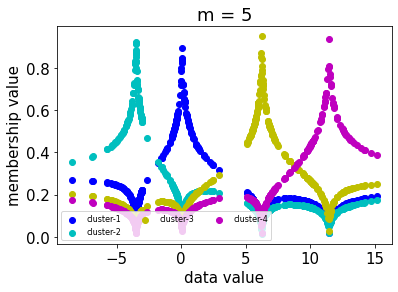

In [11]:
plt.rcParams['font.size'] = 15
color = ['b', 'c', 'y', 'm']
c1 = plt.scatter(X, U_upd[0],color=color[0])  
c2 = plt.scatter(X, U_upd[1],color=color[1]) 
c3 = plt.scatter(X, U_upd[2],color=color[2]) 
c4 = plt.scatter(X, U_upd[3],color=color[3]) 
#c5 = plt.scatter(X,U_upd[4],color=color[4])

plt.legend((c1, c2, c3, c4),
           ('cluster-1','cluster-2','cluster-3','cluster-4'),
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=8)

plt.title("m = 5")
plt.xlabel("data value")
plt.ylabel("membership value")
plt.show()

It seems, like the higher the 'm' coefficient, the tighter the membership function graph

## Reconstruction of Granulation-Degranulation

In [12]:
def degranulation(U,c):
    X = []
    for j in range(N):
        denom = 0
        num = 0
        for i in range(C):
            denom += U[i][j]**m
            num += (U[i][j]**m)*c[i]
        X.append(num/denom)
    return X

In [13]:
X = degranulation(U_upd,c_upd)

In [14]:
recon_df = pd.DataFrame(X,columns=['Value'])

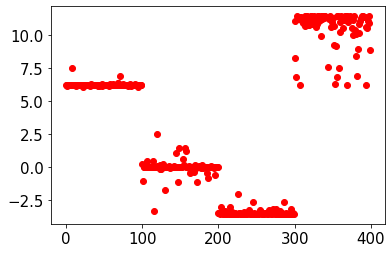

In [15]:
plt.scatter(x=recon_df.index,y=recon_df['Value'],color='red')
plt.show()

### It looks like when the fuzzification coefficient is larger, the better reconstruction is observed

# Spectral Clustering

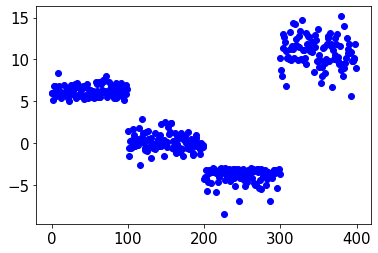

In [16]:
plt.scatter(x=list(range(len(df['Value']))),y=df['Value'],color='blue')
plt.show()

### Unnormalized Spectral clustering

Seems like 4 clusters. 

In [17]:
from sklearn.neighbors import kneighbors_graph
from scipy import sparse
from scipy import linalg
import math
def spectral_laplacian(df,nn,norm):
    #create the simmilarity graph
    graph = kneighbors_graph(df,nn,mode='connectivity')
    adjacency_graph = 1/2*(graph + graph.T)
    #create graph laplacian
    laplacian = sparse.csgraph.laplacian(adjacency_graph,normed=norm)
    laplacian = laplacian.toarray()
    eigval,eigvec = linalg.eig(laplacian)
    eigval, eigvec = np.real(eigval),np.real(eigvec)
    eig_norms = np.apply_along_axis(lambda x: np.linalg.norm(x,ord=2),axis=0,arr=eigvec)  
    print(f'Minimum norm is : {eig_norms.min()}')
    print(f'Maximum norm is : {eig_norms.max()}')
    return eigval,eigvec

In [18]:
eigval,eigvec = spectral_laplacian(df,100,False)

Minimum norm is : 0.9999999999999976
Maximum norm is : 1.0000000000000027


In [20]:
def get_cluster(eigval,eigvec,norm):
    eigenvals_sorted_indices = np.argsort(eigval)
    eigenvals_sorted = eigval[eigenvals_sorted_indices]
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.lineplot(x=range(1, eigenvals_sorted_indices.size + 1), y=eigenvals_sorted, ax=ax)
    ax.set(title='Sorted Eigenvalues Graph Laplacian', xlabel='index', ylabel=r'$\lambda$')
    #dif = np.diff(eigenvalues)
    if norm is True:
        zero_eigenvals_index = np.argwhere(abs(eigval) < 1/9)
    else:
        zero_eigenvals_index = np.argwhere(abs(eigval) < 50)
    #k_eig = eigval[zero_eigenvals_index].squeeze()
    #k = len(k_eig)
    print('index for eigengap is',zero_eigenvals_index)
    proj_df = pd.DataFrame(eigvec[:,zero_eigenvals_index.squeeze()])
    proj_df.columns = ['v_' + str(c) for c in proj_df.columns]
    return proj_df

index for eigengap is [[0]
 [1]
 [2]
 [3]]


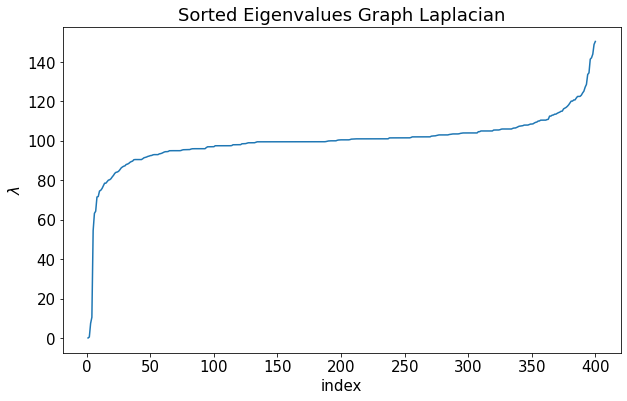

In [21]:
proj_df = get_cluster(eigval,eigvec,False)

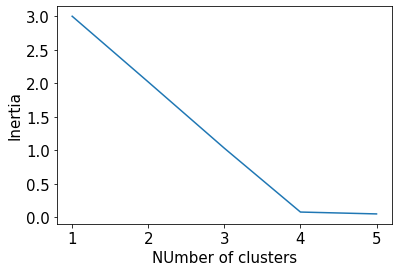

In [22]:
from sklearn.cluster import KMeans
inertias = []

k_candidates = range(1, 6)

for k in k_candidates:
    k_means = KMeans(random_state=42, n_clusters=k)
    k_means.fit(proj_df)
    inertias.append(k_means.inertia_)
plt.plot(k_candidates,inertias)
plt.xlabel("NUmber of clusters")
plt.ylabel("Inertia")
plt.show()

In [23]:
def run_k_means(df,nc):
    k_means = KMeans(random_state=25, n_clusters=nc)
    k_means.fit(df)
    cluster = k_means.predict(df)
    return cluster
#cluster

In [24]:
cluster = run_k_means(proj_df,4)

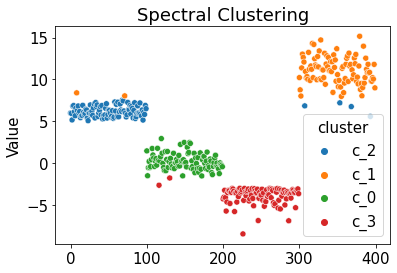

In [25]:
df['cluster'] = ['c_' + str(c) for c in cluster]

fig, ax = plt.subplots()
sns.scatterplot(x=df.index, y='Value', data=df, hue='cluster', ax=ax)
ax.set(title='Spectral Clustering');

In [26]:
df.drop(['cluster'],axis=1,inplace=True)

### Normalized clustering

In [27]:
eigval_n,eigvec_n = spectral_laplacian(df,100,True)

Minimum norm is : 0.7444140883605712
Maximum norm is : 1.0000000000000013


index for eigengap is [[0]
 [1]
 [2]
 [3]]


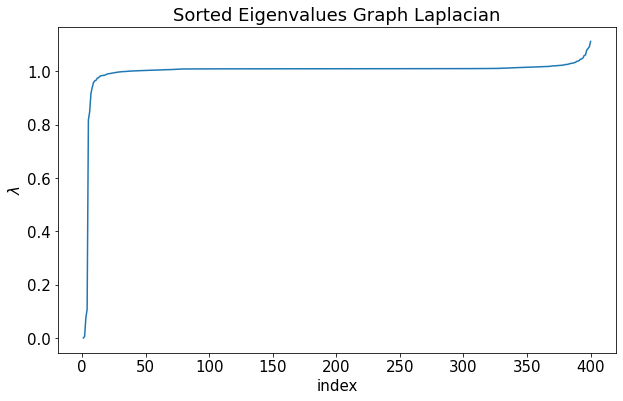

In [28]:
proj_df_1 = get_cluster(eigval_n,eigvec_n,True)

In [29]:
cluster_1 = run_k_means(proj_df_1,4)

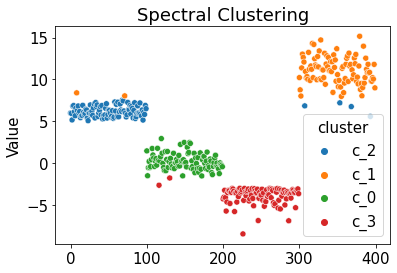

In [30]:
df['cluster'] = ['c_' + str(c) for c in cluster]

fig, ax = plt.subplots()
sns.scatterplot(x=df.index, y='Value', data=df, hue='cluster', ax=ax)
ax.set(title='Spectral Clustering');

In [31]:
df.drop(['cluster'],axis=1,inplace=True)

### This the plot for the fuzzy c means after clustering. It seems like spectral clustering did much better job. 
But this is not hard clustering , so we would expect such a cluster where we have some overlap.

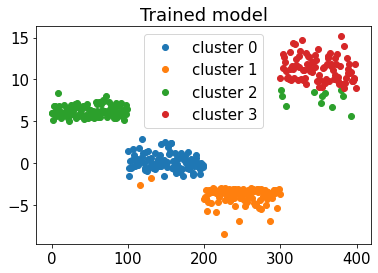

In [32]:
fig2, ax2 = plt.subplots()
ax2.set_title('Trained model')
for j in range(4):
    ax2.plot(df.index.to_numpy()[U_upd.argmax(axis=0) == j],
             df.to_numpy()[U_upd.argmax(axis=0) == j], 'o',
             label='cluster ' + str(j))
ax2.legend()

### Normalized and unormalized performed almost the same